# Mars Entry-Descent-Landing Mission Scenario

This case study demonstrates using Pacti for formalizing a simplified version of a Mars Entry-Descent-Landing mission scenario based on the following paper: [R. Prakash et al. 2008](#ref1)
and the EDL timeline from https://mars.nasa.gov/internal_resources/961/

In [6]:
from pacti.iocontract import *
from pacti.terms.polyhedra import *
import matplotlib.pyplot as plt

InVars: [u_1, u_2]
OutVars:[x_1]
A: [
  -u_1 <= 0.0
  u_1 <= 1.0
  -u_2 <= 0.0
  u_2 <= 1.0
]
G: [
  -x_1 <= -1.5
]
[0.5 0.5]
[0.25 1.75]


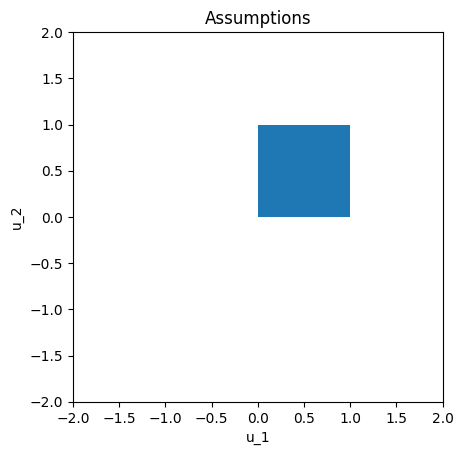

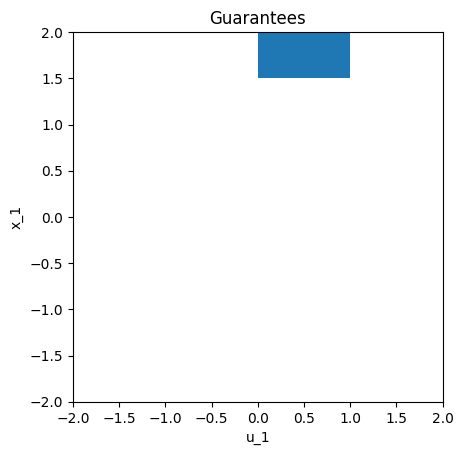

In [8]:
contract1 = {
    "InputVars":[
        "u_1",
        "u_2"
    ],
    "OutputVars":[
        "x_1"
    ],
    "assumptions":
    [
        {"coefficients":{"u_1":-1,"u_2":0}, "constant":0},
        {"coefficients":{"u_1":1,"u_2":0}, "constant":1},
        {"coefficients":{"u_1":0,"u_2":-1}, "constant":0},
        {"coefficients":{"u_1":0,"u_2":1}, "constant":1}
    ],
    "guarantees":
    [
        {"coefficients":{"x_1":-1},
        "constant":-1.5}
    ]
}
c1 = PolyhedralContract.from_dict(contract1)
print(c1)

fig = plot_assumptions(contract=c1,x_var=Var("u_1"),y_var=Var("u_2"),var_values={Var("x_1"):0},x_lims=(-2,2),y_lims=(-2,2))
fig = plot_guarantees(contract=c1,x_var=Var("u_1"),y_var=Var("x_1"),var_values={Var("u_2"):1},x_lims=(-2,2),y_lims=(-2,2))
plt.show()

https://mars.nasa.gov/mars2020/timeline/landing/entry-descent-landing/

Section: Atmospheric Entry

https://mars.nasa.gov/resources/25445/perseverance-rover-decelerating-in-the-martian-atmosphere-illustration/

In [2]:
AtmosphericEntry = PolyhedralContract.from_string(
    InputVars=[
      "t0",           # entry time
      "v0"            # entry velocity
    ],
    OutputVars=[
      "t1",           # exit time
      "v1"            # exit velocity
    ],
    assumptions=[

      # EDL begings when S/C travels at about 20,000 kph
      "v0 <= 20000"
    ],
    guarantees=[
      # Entry ends 90 seconds after start
      "t0 - t1 <= -90",

      # Exit exit velocity is below 1,600 kph
      "v1 <= 1600"
    ])

print(AtmosphericEntry)

InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  v0 <= 20000.0
]
G: [
  t0 - t1 <= -90.0
  v1 <= 1600.0
]


[  95. 1005.]


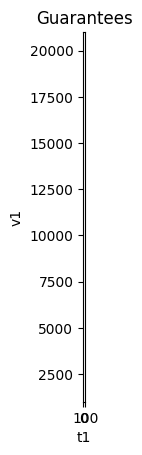

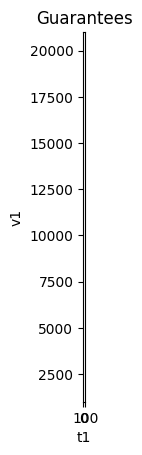

In [3]:
plot_guarantees(
    contract=AtmosphericEntry,
    x_var=Var("t1"),
    y_var=Var("v1"),
    var_values={
        Var("t0"):0,
        Var("v0"):20000.0
    },
    x_lims=(-10,100),
    y_lims=(1000, 21000)
)

In [4]:
print(AtmosphericEntry)

InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  v0 <= 20000.0
]
G: [
  -t1 <= -90.0
  v1 <= 1600.0
]


In [5]:
plot_guarantees(
    contract=AtmosphericEntry,
    x_var=Var("t0"),
    y_var=Var("v1"),
    var_values={
        Var("t1"):90,
        Var("v0"):20000.0
    },
    x_lims=(-10,100),
    y_lims=(1000, 21000)
)

[1055.   45.]


QhullError: QH6023 qhull input error: feasible point is not clearly inside halfspace
feasible point:     45   1055 
     halfspace:      0      1 
     at offset:   -100  and distance:    955 
The halfspace was at index 0

While executing:  | qhull H 
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 927681550  Halfspace  _maxoutside  0


## References

<a id="ref1"></a> __[R. Prakash et al. 2008](https://ieeexplore.ieee.org/abstract/document/4526283)__

R. Prakash et al., "Mars Science Laboratory Entry, Descent, and Landing System Overview," 2008 IEEE Aerospace Conference, Big Sky, MT, USA, 2008, pp. 1-18, doi: 10.1109/AERO.2008.4526283.
